# Introduction
In this notebook we will build and evaluate models for calculating the Probability of Default (PD). This is a frequently used metric for banks when evaluating their credit risk and accepting new clients. We will use both logisitic regression and gradient boosted trees. The aim of this project is to highlight how these models can be used, how we can evaluate their performance and which measures we can take to increase performance and pick optimal parameters.

## Data
The dataset contains fictional information on people who have taken out loans before at institution (source: [DataCamp](https://app.datacamp.com/learn/courses/credit-risk-modeling-in-python)).

Columns:
* Age (integer): The age of the person
* Income (integer): The total yearly income
* Home ownership (category): Type of current home ownership (rent, own or mortage)
* Employment length (decimal): Number of years the person has been employed for
* Loan intent (category): Why the person has taken out the loan (e.g. debt conslidation, personal, medical, ...)
* Loan grade (category): The grade of the loan (e.g. A, B, C, ...)
* Loan amount (integer): The amount that was loaned out
* Interest rate (decimal): The yearly interest that needs to be paid on the remaining principal
* Loan status (boolean): If the loan has defaulted or not (0 = non-default, 1 = default)
* Debt to income (decimal): The percentage of income used to service the outstanding debt
* Defaulted before (boolean): If the person has defaulted on a loan before
* Credit history length (integer): Years the credit history goes back for the person

# Data Exploration
By analyzing sample data and looking at descriptive statistics we can get a better feel for the data and can spot any data quality issues that need remediation.

In [1]:
# Import data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_fscore_support
from sklearn.calibration import calibration_curve
import xgboost as xgb

# Read dataset
raw_data = pd.read_csv("/kaggle/input/raw-credit-data/cr_loan2.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Explore a sample of the data
raw_data.sample(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
7905,21,47000,RENT,5.0,VENTURE,D,7000,14.96,0,0.15,Y,3
20559,27,98004,RENT,8.0,HOMEIMPROVEMENT,A,10000,6.54,0,0.10,N,10
8131,23,49980,MORTGAGE,7.0,MEDICAL,B,4800,10.37,1,0.10,N,2
7264,25,25000,RENT,3.0,MEDICAL,A,6325,8.90,0,0.25,N,4
22430,29,55000,MORTGAGE,4.0,PERSONAL,B,8000,10.00,0,0.15,N,6


In [3]:
# Explore the columns
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


We can derive that there are missing values for the employment length and interest rate.

In [4]:
avg_loan_amnt = raw_data['loan_amnt'].mean()

# Summary statistics
raw_data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


Some interesting findings:
* The average loan amount is \\$9,589.37 ± $6,322.09 with an average interest rate of 11.01% ± 3.24%.
* 21.8% of all loans in our portfolio have defaulted. 
* There are data quality problems: age of 144 and employmnet length of 123.

In [5]:
# Summary statistics for categorical values
raw_data.describe(include="O")

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,32581,32581,32581,32581
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,16446,6453,10777,26836


Most people in or data set rent and take out a loan to fund their education.

From the summary count statistics we can derive that there are columns with missing values. Let's check which columns have the most missing values.

In [6]:
# Calculate the percentage of values being NaN for each column
rows = len(raw_data)
missing = raw_data.isnull().sum()
percentage_missing = missing / rows

# Put the data in a DataFrame and sort it
percentage_missing_df = pd.DataFrame({'Missing' : percentage_missing})
percentage_missing_df.sort_values('Missing', ascending = False, inplace = True)

# Print columns with percentage of missing values
percentage_missing_df.style.format("{:.1%}")

,Missing
loan_int_rate,9.6%
person_emp_length,2.7%
person_age,0.0%
person_income,0.0%
person_home_ownership,0.0%
loan_intent,0.0%
loan_grade,0.0%
loan_amnt,0.0%
loan_status,0.0%
loan_percent_income,0.0%


We are able to verify that the interest rate is missing for 9.6% of rows and the age is missing for 2.7% of rows.

In [7]:
# Find all duplicate rows
duplicates = raw_data[raw_data.duplicated(keep=False)]
    
# Count occurrences of each duplicated row
duplicate_counts = duplicates.value_counts().reset_index(name='Count')

# Group duplicate rows by their duplication count
duplicate_counts['Count'].value_counts()

2    137
Name: Count, dtype: int64

We  have 137 duplicate rows in our data set of +30,000 rows, each appearing twice. Duplicate rows can indicate a data quality problem, especially if the same record is repeated many times. It is however not impossible as our data does not contain any unique identifiers.

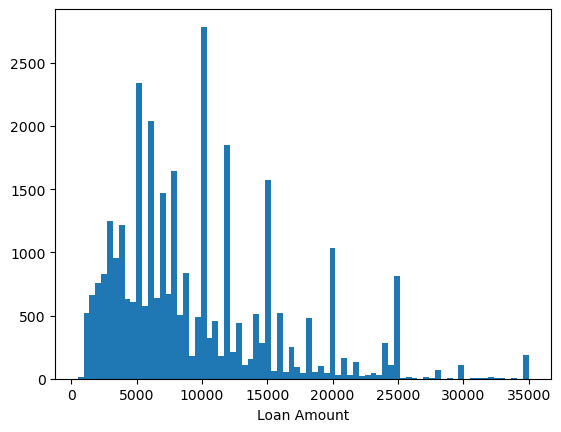

In [8]:
# Look at the distribution of loan amounts with a histogram
n, bins, patches = plt.hist(x=raw_data['loan_amnt'], bins='auto')
plt.xlabel("Loan Amount")
plt.show()

We have a right-skewed distribution of loan amounts with spikes at loan amounts of rounded numbers

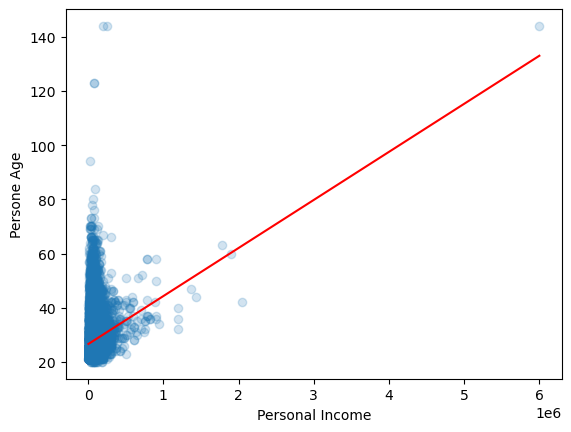

Equation of the trendline: y = 0.00001774x + 26.56


In [9]:
# Plot a scatter plot of income against age
plt.scatter(raw_data['person_income'], raw_data['person_age'], alpha = 0.2)

# Fit a linear regression model using NumPy
coefficients = np.polyfit(raw_data['person_income'], raw_data['person_age'], 1)
linear_fit = np.poly1d(coefficients)

# Generate the x values for the trendline (min and max income values)
income_range = np.linspace(raw_data['person_income'].min(), raw_data['person_income'].max(), 100)

# Plot the trendline
plt.plot(income_range, linear_fit(income_range), color='red', label='Linear Trendline')

plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.show()

# Show trendline equation
slope, intercept = coefficients
equation = f'y = {slope:.8f}x + {intercept:.2f}'
print("Equation of the trendline:", equation)

By analyzing a scatterplot of the age and income of a person, we can spot a positive correlation, which could mean these older recipients are further along in their career and therefore earn higher salaries. There also appears to be some outliers in the data, as well as a data problem with people being older than 120 years.

Cross tables in Python are similar to pivot tables in Excel, you get a high level view of selected columns with aggregation like a count or average. For most credit risk models, especially for probability of default, columns like loan intent and home ownership are common to begin investigating.

In [10]:
# Create a cross table of the loan intent and loan status
pd.crosstab(raw_data['loan_intent'], raw_data['loan_status'], margins=True, normalize='index').style.format("{:.0%}")

loan_status,0,1
loan_intent,,
DEBTCONSOLIDATION,71%,29%
EDUCATION,83%,17%
HOMEIMPROVEMENT,74%,26%
MEDICAL,73%,27%
PERSONAL,80%,20%
VENTURE,85%,15%
All,78%,22%


People taking out loans for debt consolidation, home improvement and medical reasons seem to default more frequently.

In [11]:
# Create a cross table of home ownership, loan status, and grade
pd.crosstab(raw_data['person_home_ownership'], [raw_data['loan_status'], raw_data['loan_grade']], normalize='columns').round(4).style.format("{:.0%}")

Defaulted loans seem to occur more frequently with those who rent.

In [12]:
# Create a cross table of home ownership, loan status, and average percent income
pd.crosstab(raw_data['person_home_ownership'], raw_data['loan_status'], values=raw_data['loan_percent_income'], aggfunc='mean').style.format("{:.0%}")

loan_status,0,1
person_home_ownership,,
MORTGAGE,15%,18%
OTHER,14%,30%
OWN,18%,30%
RENT,14%,26%


The debt-to-income is higher for all types of home ownership when comparing defaults to non-defaults.

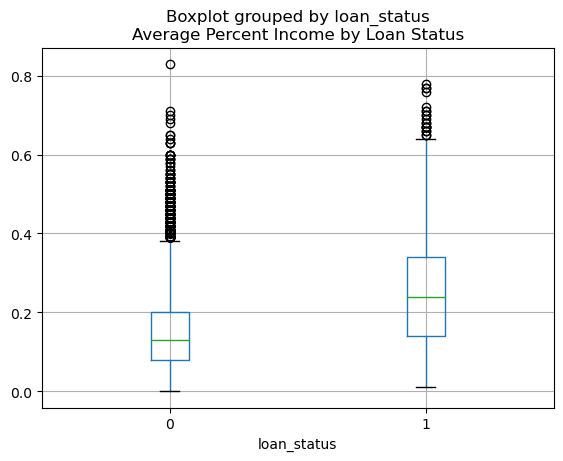

In [13]:
# Create a box plot of percentage income by loan status
raw_data.boxplot(column=['loan_percent_income'], by='loan_status')
plt.title('Average Percent Income by Loan Status')
plt.show()

It looks like the average debt-to-income for defaults is higher. This could indicate those recipients have a debt-to-income ratio that's already too high at acceptance.

# Data Cleaning
The first type of preparation we will look at is outlier detection and removal. With outliers in our training data, our predictive models will have a difficult time estimating parameters like coefficients. This can cause our models to not predict as many defaults.

An employment length of over 60 seems highly unlikely, so we will remove those data points.

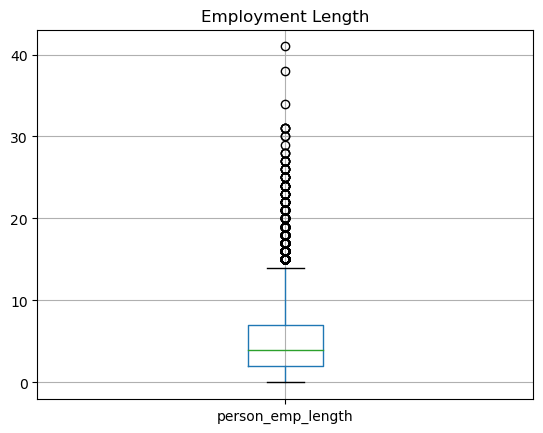

In [14]:
# Create an array of indices where employment length is greater than 60
indices = raw_data[raw_data['person_emp_length'] > 60].index

# Drop the records from the data based on the indices and create a new dataframe
data_clean = raw_data.drop(indices)

# Create a box plot to verify we no longer have excessive employment length results
data_clean.boxplot(column=['person_emp_length'])
plt.title('Employment Length')
plt.show()

An employment length between 0 and 41 seems reasonable.

Earlier we noticed some records with ages above 120, let's fix this data quality issue.

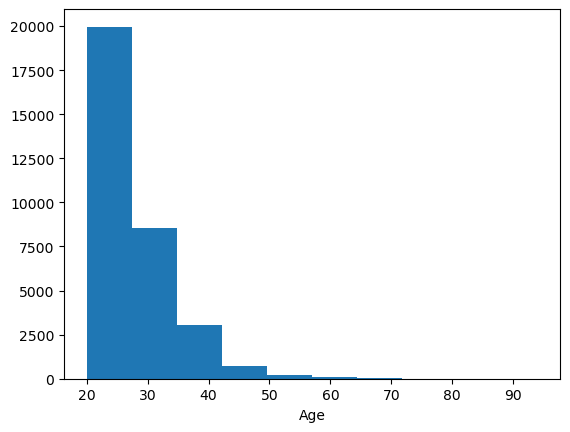

In [15]:
# Use Pandas to drop the record from the data frame and create a new one
data_clean = data_clean.drop(data_clean[data_clean['person_age'] > 100].index)

# Look at the distribution of ages with a histogram
n, bins, patches = plt.hist(x=data_clean['person_age'])
plt.xlabel("Age")
plt.show()

We've tackled the problem of outliers for both age and employment length. Next we'll need to handle missing values. Missing values also negatively impact predictive model performance. It can bias our model in unanticipated ways, which can affect how we predict defaults. We can decide to either drop rows containing missing values or replace these missing values with a mean or median value. Earlier we saw that there are missing values for employment length and interest rate. 

We decide to impute the missing values for employment length with the median value, whereas we will drop those rows having no interest rate. 

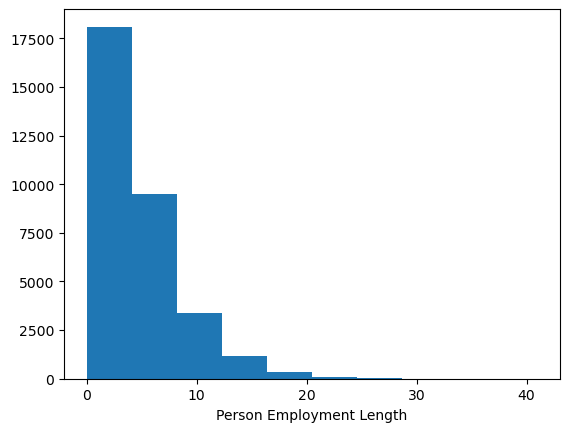

In [16]:
# Impute the null values with the median value for all employment lengths
data_clean['person_emp_length'].fillna((data_clean['person_emp_length'].median()), inplace=True)

# Create a histogram of employment length
n, bins, patches = plt.hist(data_clean['person_emp_length'])
plt.xlabel("Person Employment Length")
plt.show()

Employment length is right-skewed as younger people tend to apply more often for loans than older people who have worked for longer.

In [17]:
# Store the array on indices
indices = data_clean[data_clean['loan_int_rate'].isnull()].index

# Save the new data without missing data
data_clean = data_clean.drop(indices)

# Calculate the percentage of values being NaN for each column
rows = len(data_clean)
missing = data_clean.isnull().sum()
percentage_missing = missing / rows

# Put the data in a DataFrame and sort it
percentage_missing_df = pd.DataFrame({'Missing' : percentage_missing})
percentage_missing_df.sort_values('Missing', ascending = False, inplace = True)

# Print columns with percentage of missing values
percentage_missing_df.style.format("{:.1%}")

,Missing
person_age,0.0%
person_income,0.0%
person_home_ownership,0.0%
person_emp_length,0.0%
loan_intent,0.0%
loan_grade,0.0%
loan_amnt,0.0%
loan_int_rate,0.0%
loan_status,0.0%
loan_percent_income,0.0%


There are no more columns with missing data as we either dropped those rows or imputed those values.

# Logistic Regression
Probability of default is the likelihood that someone will fail to repay a loan. This is expressed as a probability which is a value between zero and one. These probabilities are associated with our loan status column where a 1 is a default, and a 0 is a non-default. The resulting predictions give us probabilities of default. The closer the value is to 1, the higher the probability of the loan being a default.

To get these probabilities, we train machine learning models on our credit data columns, known as features, so the models learn how to use the data to predict the probabilities. These types of models are known as classification models, where the class is default or non-default. In the industry, two models are used frequently. These are logistic regressions, and decision trees. Both of these models can predict the probability of default, and tell us how important each column is for predictions.

The logistic regression is a regression that only produces a value between 0 and 1. Logistic regressions perform better on data when what determines a default or non-default can vary greatly.

$$logit(Non-Default) = log[P(Y = 0) / (1 - P(Y = 0))]$$

Scikit learn has a logistics model function that will optimize the feature coeffiecients through brute force trial-and-error.

We will need to split our data in two separate groups, part of our data we will use to train our model - the training set - another part of our data we will use to test and validate the performance of our model - the test set. We use the majority of the data to train our models, so they learn as much as possible from the data. Our test set is used to see how our model reacts to new data that it has not seen before. 

In [18]:
# Create the X and y data sets
X = data_clean[['loan_int_rate','person_emp_length','person_income', 'loan_amnt']]
y = data_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
X_test_performance = X_test[['loan_amnt']]
X_train = X_train[['loan_int_rate','person_emp_length','person_income']]
X_test = X_test[['loan_int_rate','person_emp_length','person_income']]

# Create and fit the logistic regression model
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
clf_logistic.coef_

array([[ 1.28517496e-09, -2.27622202e-09, -2.17211991e-05]])

These coefficients indicate the importance of each column. These values are part of the logistic regression formula that calculates the probability of default.

Our data contains non-numeric columns like loan intent, which uses words to describe how the person plans to use the money we lend them. We have to perform one-hot encoding before we can use them. The main idea is to represent a string with a numeric value. This will get us a new set of columns where each value from loan intent is now its own column. Each new column is created by separating out the loans with each intent value and making the new column's value a 0 or 1. For example, if the loan intent was education, it is now represented with a 1 in the loan intent education column. This way, there is one hot value.

To one-hot encode our string columns, we use the get dummies function within pandas. First, we separate the numeric and non-numeric columns from the data into two sets. Then we use the get dummies function to one-hot encode only the non-numeric columns. We union the two sets and the result is a full data set.

Once our model is trained, we use the predict proba method on test data to make predictions. This creates a set of probabilities for non-default and default. Notice the output is a series of numbers between 0 and 1. We have two for each loan. The first number is the probability of non-default, and the second number is the probability of default.

In [19]:
# Create two data sets for numeric and non-numeric data
data_num = data_clean.select_dtypes(exclude=['object'])
data_str = data_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
data_str_onehot = pd.get_dummies(data_str)

# Union the one-hot encoded columns to the numeric ones
data_prep = pd.concat([data_num, data_str_onehot], axis=1)

# Print the columns in the new data set
data_prep.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

In [20]:
# Create the X and y data sets
X = data_prep.drop(columns=['loan_status'])
y = data_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1).style.format({"prob_default":"{:.1%}"})

,loan_status,prob_default
0,1,44.6%
1,1,22.3%
2,0,28.9%
3,0,16.9%
4,1,11.4%


The first five rows don't look very promising, defaulted loans seem to have a low PD.

## Model Evaluation
There are several metric to evaluate the performance of a model.
* Accuracy: Accuracy is the number of correct predictions divided by the total number of predictions.
* ROC charts: ROC charts plot the true positive rate, the percentage of correctly predicted defaults, against the false positive rate, the percentage of incorrectly predicted defaults. The more the ROC curve goes towards the top-left corner (lift) the better the models predictions. This allows us to calculate the area under the curve (AUC), representing the space between the curve and a random model indicated by a straight diagonal line.

In [21]:
# Create a dataframe for the probabilities of default
preds_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the row counts for each loan status
preds_df['loan_status'].value_counts()

0    11175
1      609
Name: loan_status, dtype: int64

We classify loans with a PD of more than 50% as default loans. This gets us 609 defaulted loans vs 11,175 non-defaulted loans.

In [22]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df['loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.81      0.98      0.89      9198
     Default       0.71      0.17      0.27      2586

    accuracy                           0.80     11784
   macro avg       0.76      0.57      0.58     11784
weighted avg       0.79      0.80      0.75     11784



Recall is the proportion of actual positives correctly predicted. This is found by taking the number of true defaults and dividing it by the sum of true defaults and defaults predicted as non-default. For our model the recall for defaults is 17%, meaning that only 17% of our defaulted loans were predicted as defaults.

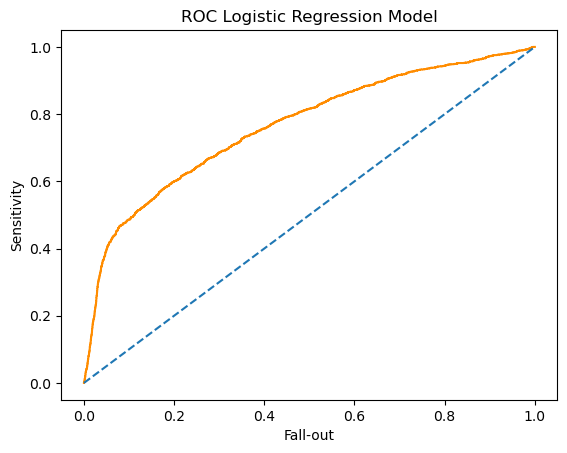

Accuracy: 0.8025288526816021
AUC: 0.7643248801355148


In [23]:
# Create predictions and store them in a variable
preds = clf_logistic.predict_proba(X_test)

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.title("ROC Logistic Regression Model")
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
                                   
# Print the accuracy and AUC score the model
print("Accuracy:", clf_logistic.score(X_test, y_test))
print("AUC:", auc)

The ROC curve shows the trade-off between the false positive rate (fall-out) on the x-axis, and the true positive rate (sensitivity) on the y-axis.  The accuracy for this model is about 80% and the AUC score is 76%.

In [24]:
# Set the threshold for defaults to 0.5
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print("Default threshold 50%\n", confusion_matrix(y_test,preds_df['loan_status']),"\n")

# Set the threshold for defaults to 0.4
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion matrix
print("Default threshold 40%\n", confusion_matrix(y_test,preds_df['loan_status']))

Default threshold 50%
 [[9023  175]
 [2152  434]] 

Default threshold 40%
 [[8476  722]
 [1386 1200]]


A confusion matrix shows use true and false positives and negatives. We get a much better default recall when lowering our PD threshold to classify defaults. 50%: 434 vs 40%: 1,200

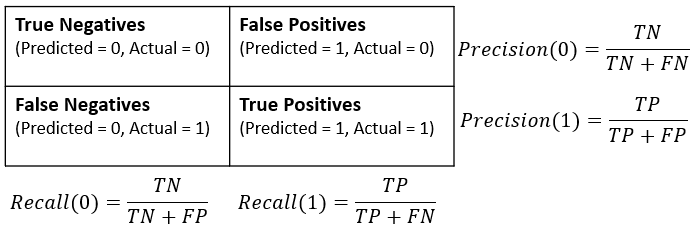

In [25]:
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = preds_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

9878209.193321576


We calculate the unexpected loss by multiplying the amount of loans we did not identify as default but actually defaulted by the average loan amount. With a PD threshold of 40% this would be $9.8M. We need to check other thresholds to see if those would result in a lower unexpected loss.

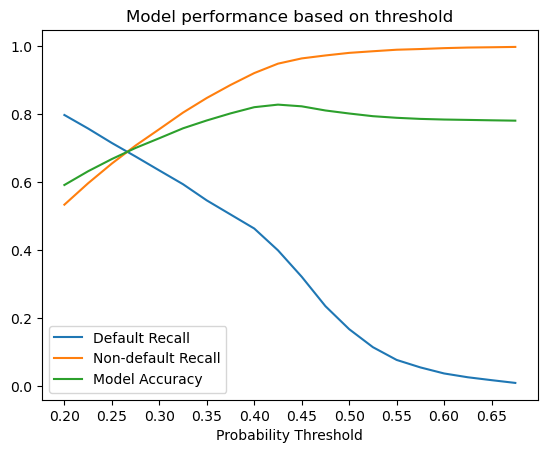

[0.032358744385569516, 0.275]

In [26]:
thresh = [0.2 + i * 0.025 for i in range(20)]
ticks = [thresh[i] for i in range(len(thresh)) if i % 2 == 0]
def_recalls = []
nondef_recalls = []
accs = []

for thresh_value in thresh:
    # Reassign the values of loan status based on the new threshold
    preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > thresh_value else 0)

    # Store the default recall from the classification report
    default_recall = precision_recall_fscore_support(y_test, preds_df['loan_status'])[1][1]
    nondefault_recall = precision_recall_fscore_support(y_test,preds_df['loan_status'])[1][0]
    accuracy = accuracy_score(y_test,preds_df['loan_status'])

    # Append the default recall value to the list
    def_recalls.append(default_recall)
    nondef_recalls.append(nondefault_recall)
    accs.append(accuracy)

plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(ticks)
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
plt.title("Model performance based on threshold")
plt.show()

# Find the threshold where default recall and non-default recall intersect
intersect = [1, 1]
for i, thresh_value in enumerate(thresh):
    difference = abs(def_recalls[i] - nondef_recalls[i])
    if (difference < intersect[0]):
        intersect = [difference, thresh_value]
        
intersect

There is a trade off between metrics like default recall, non-default recall, and model accuracy. The graph above shows us the performance of those parameters based on the probability threshold. Where the lines intersect shows us the optimal trade-off, in this case being a PD of 0.275. This threshold would make a great starting point, but declaring all loans above 0.275 PD to be a default is probably not practical.

# Gradient Boosted Trees with XGBoost
Gradient boosted trees are machine learning models which use decisions as steps in a process to eventually identify our loan status. The results of these steps are yes and no decisions that eventually lead to a predicted loan status of default or non-default. XGBoost doesn't use just one decision tree, but a large number of them in what's known as an ensemble through a method called gradient boosting. Each tree in the ensemble is a weak predictor, combined they are much better. These models predict the same way in Python as the logistic regression do.

The models have parameters that are like settings that affect how a model learns. These settings are called hyperparameters. Hyperparameters cannot be learned from data; they have to be set by us. The learning rate tells the model how quickly it should learn in each step of the ensemble. The smaller the value, the more conservative it is at each step. The max depth tells the model how deep each tree can go. Keeping this value low ensures the model is not too complex.

In [27]:
# Train a model
clf_gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Predict with a model
gbt_preds = clf_gbt.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
gbt_preds_df = pd.DataFrame(gbt_preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
pd.concat([true_df.reset_index(drop = True), gbt_preds_df], axis = 1).style.format({"prob_default":"{:.1%}"})

,loan_status,prob_default
0,1,99.1%
1,1,98.4%
2,0,0.1%
3,0,0.1%
4,1,8.5%


At first glance, the XGBoost model seems to predict defaults better - getting 2 out of 3 - than logistic regression.

In [28]:
# Print the first five rows of the portfolio data frame
lr_preds_df = preds_df.drop(columns=['loan_status'])
lr_preds_df.columns = ['lr_prob_default']
gbt_preds_df = pd.DataFrame(gbt_preds[:,1], columns = ['gbt_prob_default'])
portfolio = pd.concat([X_test_performance.reset_index(drop = True), lr_preds_df, gbt_preds_df], axis=1)
print(portfolio.head())

# Create expected loss columns for each model using the formula
lgd = 0.2
portfolio['lr_expected_loss'] = portfolio['lr_prob_default'] * lgd * portfolio['loan_amnt']
portfolio['gbt_expected_loss'] = portfolio['gbt_prob_default'] * lgd * portfolio['loan_amnt']

# Print the sum of the expected loss for lr and gbt
print('LR expected loss: ', np.sum(portfolio['lr_expected_loss']))
print('GBT expected loss: ', np.sum(portfolio['gbt_expected_loss']))

   loan_amnt  lr_prob_default  gbt_prob_default
0      15000         0.445779          0.990942
1      11200         0.223447          0.983987
2      15000         0.288558          0.000807
3      10800         0.169358          0.001239
4       3000         0.114182          0.084892
LR expected loss:  5596776.979852879
GBT expected loss:  5383982.895634945


Expected loss (EL) = probability of default (PD) * loss given default (LGD) * exposure at default (EAD)

In this case we assume the LGD to be a fixed 20%, in a real use case, this would also be moddeled.

It looks like the total expected loss for the XGBoost model is quite a bit lower ($212,794.08) than the one of the logsitic regression model. When we talk about accuracy and precision, the goal is to generate models which have a low expected loss.

In [29]:
# Predict the labels for loan status
gbt_preds = clf_gbt.predict(X_test)

# Check the values created by the predict method
print(gbt_preds)

# Print the classification report of the model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

[1 1 0 ... 0 0 0]
              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.74      0.83      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784



The default recall for the logistic regression model was only 17%. The XGBoost model offers a big improvement on this front with a default recall of 74%. All recall and precision parameters of this model are very high and quite a bit better than those of the logistic regression.

In [30]:
X = data_prep[['person_income','loan_int_rate', 'loan_percent_income','loan_amnt', 'person_home_ownership_MORTGAGE','loan_grade_F']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and train the model on the training data
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))

# Print the column importances from the model
clf_gbt.get_booster().get_score(importance_type = 'weight')

{'person_income': 1299.0,
 'loan_int_rate': 1001.0,
 'loan_percent_income': 515.0,
 'loan_amnt': 519.0,
 'person_home_ownership_MORTGAGE': 116.0,
 'loan_grade_F': 9.0}

The coefficients of a logistic regression indicate the importance of each column in predicting the outcome. For gradient boosted trees we can look at the weight, this will give us how many times the columns appear in all the models' trees.

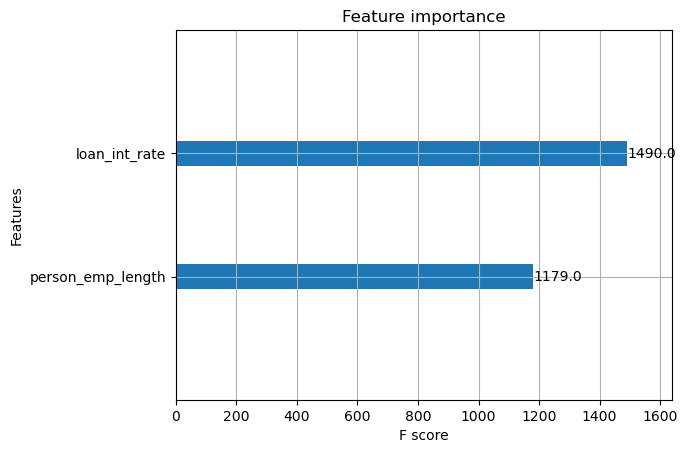

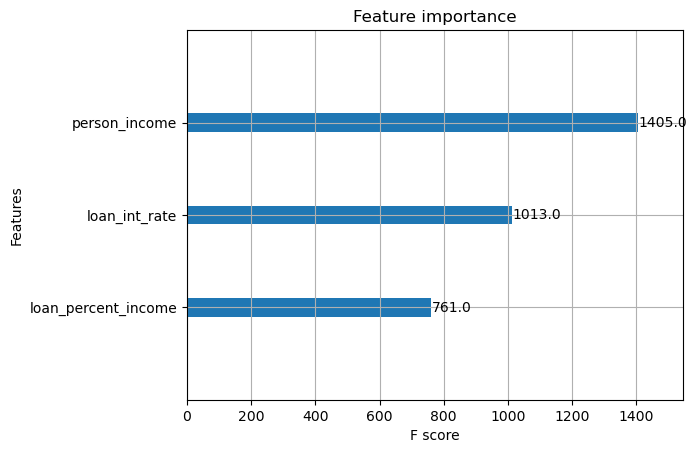

In [31]:
X2 = data_prep[['loan_int_rate','person_emp_length']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=.4, random_state=123)

# Train a model on the X data with 2 columns
clf_gbt2 = xgb.XGBClassifier().fit(X2_train,np.ravel(y2_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt2, importance_type = 'weight')
plt.show()

# Add DTI to our model parameters
X3 = data_prep[['person_income','loan_int_rate','loan_percent_income']]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=.4, random_state=123)

# Train a model on the X data with 3 columns
clf_gbt3 = xgb.XGBClassifier().fit(X3_train,np.ravel(y3_train))

# Plot the column importance for this model
xgb.plot_importance(clf_gbt3, importance_type = 'weight')
plt.show()

The amount of columns used to train the model can affect the importance of them. In this case adding the Income column reduced the weight of the Interest Rate column from 1,490 to 1,013.

In [32]:
# Create data sets and models
X = data_prep[['person_income','loan_int_rate', 'loan_percent_income', 'loan_amnt', 'person_home_ownership_MORTGAGE']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

X2 = data_prep[['person_income','loan_int_rate', 'loan_percent_income', 'person_emp_length', 'person_home_ownership_RENT']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=.4, random_state=123)
gbt2 = xgb.XGBClassifier().fit(X2_train, np.ravel(y2_train))

# Predict the loan_status using each model
gbt_preds = gbt.predict(X_test)
gbt2_preds = gbt2.predict(X2_test)

# Print the classification report of the first model
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))

# Print the classification report of the second model
print(classification_report(y_test, gbt2_preds, target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.91      0.95      0.93      9198
     Default       0.79      0.66      0.72      2586

    accuracy                           0.89     11784
   macro avg       0.85      0.81      0.83     11784
weighted avg       0.88      0.89      0.88     11784

              precision    recall  f1-score   support

 Non-Default       0.91      0.97      0.94      9198
     Default       0.88      0.66      0.75      2586

    accuracy                           0.90     11784
   macro avg       0.89      0.82      0.85     11784
weighted avg       0.90      0.90      0.90     11784



It can be difficult to use two metrics like accuracy and recall to gauge a model's performance. The F1 score is a combination of both precision and recall. This is useful because it helps us keep recall for loan defaults as an important consideration for any model. 

F1 = 2 * (precision * recall) / (precision + recall)

In [33]:
# Create data sets and models
X = data_prep.drop(columns=['loan_status'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
gbt = xgb.XGBClassifier().fit(X_train, np.ravel(y_train))

# Set the values for number of folds and stopping iterations
n_folds = 5
early_stopping = 10
params = {'objective': 'binary:logistic', 'seed': 123, 'eval_metric': 'auc'}

# Create the DTrain matrix for XGBoost
DTrain = xgb.DMatrix(X_train, label = y_train)

# Create the data frame of cross validations
xgb.cv(params, DTrain, num_boost_round = 5, nfold=n_folds, early_stopping_rounds=early_stopping).style.format("{:.1%}")

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,89.8%,0.1%,89.3%,0.5%
1,90.9%,0.2%,90.3%,0.5%
2,91.4%,0.2%,90.7%,0.4%
3,91.9%,0.1%,91.1%,0.5%
4,92.2%,0.2%,91.4%,0.4%


Cross validation is a method for training and testing a model multiple times on the same data with different hyperparameters. We cannot create more loan data to help us develop our model, but we can use cross validation to simulate how our model will perform on new loan data before it comes in. 

We take the entire set of training data and create pieces, called folds, from it. All but one of the folds are used for training, and the remaining fold is used as a kind of miniature test set. Once testing on all folds is completed, the model is tested against the actual test set. This is done through multiple splits so each fold is used for testing at least once. Once this is done, the parameters are averaged across each training session and then the model is finally tested against the original test set.

The AUC for both train-auc-mean and test-auc-mean improves at each iteration of cross-validation.

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.897568       0.000909       0.892900      0.008258
1        0.906985       0.002611       0.901162      0.007519
2        0.913678       0.001404       0.907910      0.007753
3        0.919123       0.000921       0.912130      0.007145
4        0.922864       0.001097       0.914962      0.006706
Mean test AUC score: 0.94


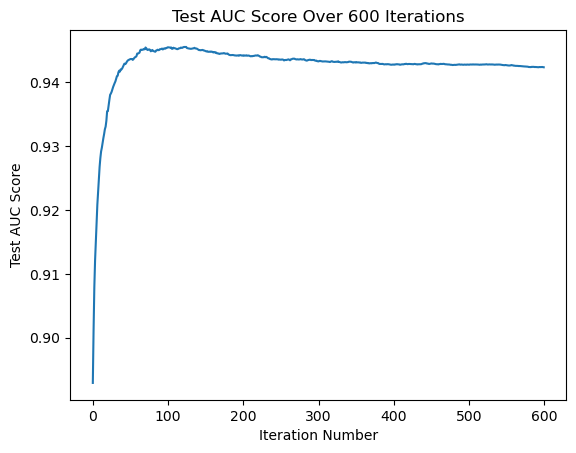

In [34]:
cv_results_big = xgb.cv(params, DTrain, num_boost_round = 600, nfold=10, shuffle = True)

# Print the first five rows of the CV results data frame
print(cv_results_big.head())

# Calculate the mean of the test AUC scores
print("Mean test AUC score:", np.mean(cv_results_big['test-auc-mean']).round(2))

# Plot the test AUC scores for each iteration
plt.plot(cv_results_big['test-auc-mean'])
plt.title('Test AUC Score Over 600 Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Test AUC Score')
plt.show()

The test AUC score never quite reaches 1.0 and begins to decrease slightly after 100 iterations. This is because too much cross-validation can actually cause the model to become overfit. So, there is a limit to how much cross-validation we should do.

In [35]:
# Create the X and y data sets
X = data_prep.drop(columns=['loan_status'])
y = data_prep[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create a gradient boosted tree model using two hyperparameters
gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7)

# Calculate the cross validation scores for 4 folds
cv_scores = cross_val_score(gbt, X_train, np.ravel(y_train), cv = 4)

# Print the cross validation scores
print(cv_scores)

# Print the average accuracy and standard deviation of the scores
print("Average accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(),
                                              np.std(cv_scores) * 2))

[0.94048427 0.93256393 0.93324282 0.92462653]
Average accuracy: 0.93 (+/- 0.01)


Setting the hyperparameters in combination with cross validation, we've managed to increase the accuracy of our model to 93%.

In [36]:
X_y_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
count_nondefault, count_default = X_y_train['loan_status'].value_counts()

# Create data sets for <defaults and non-defaults
nondefaults = X_y_train[X_y_train['loan_status'] == 0]
defaults = X_y_train[X_y_train['loan_status'] == 1]

# Undersample the non-defaults
nondefaults_under = nondefaults.sample(count_default, random_state=123)

# Concatenate the undersampled nondefaults with defaults
X_y_train_under = pd.concat([nondefaults_under.reset_index(drop = True),
                             defaults.reset_index(drop = True)], axis = 0)

# Print the value counts for loan status
X_y_train_under['loan_status'].value_counts()

0    3877
1    3877
Name: loan_status, dtype: int64

In our credit data, the values for loan status are our classes. By looking at the value counts, we see that the number of defaults and non-defaults is not equal. In the training data, the defaults account for 22%. So, there are far more non-defaults than defaults. This is class imbalance, which is a problem. Our tree models use a loss function called log-loss. Our model will want to predict both classes accurately as this leads to an overall better score. Let's say we have one default and one non-default. Each has a predicted probability far away from the actual loan status. With the log-loss function, both result in the same value. So, for our model each is equally bad. The problem is, for loans, a default predicted to be a non-default is much more costly.

What causes class imbalance can be several different things. One is there might be some issues with the data itself. Maybe the training data was not sampled correctly. For us, the imbalance is perfectly normal. People have incentives to not default on loans. One example is the less often they default, their credit rating goes up and they are able to purchase more things.

We will use under-sampling to solve for class-imbalance. We take a random sample of non-defaults and combine it with our defaults. Imagine we have 100 loans where 80% are non-defaults. We will randomly sample only 20 of our non-defaults, and combine that with our set of 20 defaults. With this, we have a balanced training set of 20 defaults and 20 non-defaults.

After under sampling our training set has an even number of defaults and non-defaults of 3,877.

In [37]:
# Create the X and y data sets
X = data_prep.drop(columns=['loan_status'])
y = data_prep[['loan_status']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

X_train_under = X_y_train_under.drop(columns=['loan_status'])
y_train_under = X_y_train_under[['loan_status']]

# Train the models
gbt = xgb.XGBClassifier(learning_rate = 0.2, max_depth = 7)
clf_gbt = gbt.fit(X_train, np.ravel(y_train))
gbt_preds = clf_gbt.predict(X_test)

clf_gbt2 = gbt.fit(X_train_under, np.ravel(y_train_under))
gbt2_preds = clf_gbt2.predict(X_test)

# Check the classification reports
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, gbt_preds, target_names=target_names))
print(classification_report(y_test, gbt2_preds, target_names=target_names))

# Print the confusion matrix for both old and new models
print(confusion_matrix(y_test,gbt_preds))
print(confusion_matrix(y_test,gbt2_preds), "\n")

# Print and compare the AUC scores of the old and new models
print(roc_auc_score(y_test, gbt_preds))
print(roc_auc_score(y_test, gbt2_preds))

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.95      0.73      0.83      2586

    accuracy                           0.93     11784
   macro avg       0.94      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784

              precision    recall  f1-score   support

 Non-Default       0.95      0.92      0.93      9198
     Default       0.74      0.82      0.78      2586

    accuracy                           0.90     11784
   macro avg       0.84      0.87      0.85     11784
weighted avg       0.90      0.90      0.90     11784

[[9105   93]
 [ 691 1895]]
[[8437  761]
 [ 465 2121]] 

0.8613405315086655
0.8687251187966314


Our most important metric is default recall, as we want to be sure to classify each default as a default, because a default predicted as non-default is more costly.

Undersampling the training data results in more false positives, but the recall for defaults and the AUC score are both higher than the original model. This means overall it predicts defaults much more accurately.

## Model evaluation

In [38]:
# Reassign the values of loan status based on the new threshold
preds_df['loan_status'] = preds_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)
preds_df_lr = preds_df

gbt = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 7, gamma = 1, reg_lambda = 1.2, min_split_loss = 1.0)
clf_gbt = gbt.fit(X_train, np.ravel(y_train))
preds_df_gbt = clf_gbt.predict_proba(X_test)
preds_df_gbt = pd.DataFrame(preds_df_gbt[:,1], columns = ['prob_default'])
preds_df_gbt['loan_status'] = preds_df_gbt['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the logistic regression classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_lr['loan_status'], target_names=target_names))

# Print the gradient boosted tree classification report
print(classification_report(y_test, preds_df_gbt['loan_status'], target_names=target_names))

# Print the default F-1 scores for the logistic regression
print(precision_recall_fscore_support(y_test, preds_df_lr['loan_status'], average = 'macro')[2])

# Print the default F-1 scores for the gradient boosted tree
print(precision_recall_fscore_support(y_test, preds_df_gbt['loan_status'], average = 'macro')[2])


              precision    recall  f1-score   support

 Non-Default       0.86      0.92      0.89      9198
     Default       0.62      0.46      0.53      2586

    accuracy                           0.82     11784
   macro avg       0.74      0.69      0.71     11784
weighted avg       0.81      0.82      0.81     11784

              precision    recall  f1-score   support

 Non-Default       0.93      0.99      0.96      9198
     Default       0.94      0.73      0.82      2586

    accuracy                           0.93     11784
   macro avg       0.93      0.86      0.89     11784
weighted avg       0.93      0.93      0.93     11784

0.7108943782814463
0.8909014142736051


Both precesion and recall scores are a lot higher for the gradient boosted tree model.

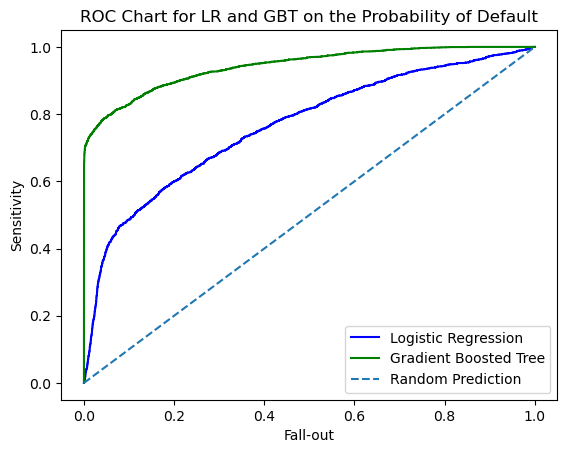

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.94


In [39]:
# ROC chart components
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, preds_df_lr['prob_default'])
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, preds_df_gbt['prob_default'])

# ROC Chart with both
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'Gradient Boosted Tree')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

# Print the logistic regression AUC with formatting
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, preds_df_lr['prob_default']))

# Print the gradient boosted tree AUC with formatting
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, preds_df_gbt['prob_default']))

The lift is how far the curve is from the random prediction. The AUC is the area between the curve and the random prediction. The model with more lift, and a higher AUC, is the one that's better at making predictions accurately. When looking at the ROC curve and AUC, it's clear that the gradient boosted tree performs much better.

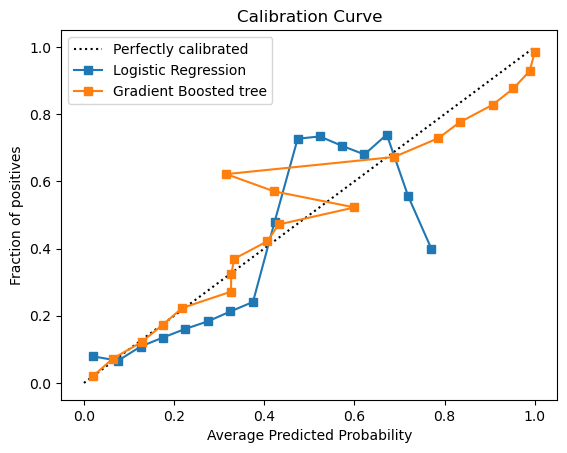

In [40]:
# Generate calibration curve values
frac_of_pos_lr = calibration_curve(y_test, preds_df_lr['prob_default'], n_bins=20)[0]
mean_pred_val_lr = calibration_curve(y_test, preds_df_lr['prob_default'], n_bins=20)[1]
frac_of_pos_gbt = calibration_curve(y_test, preds_df_gbt['prob_default'], n_bins=20)[0]
mean_pred_val_gbt = calibration_curve(y_test, preds_df_gbt['prob_default'], n_bins=20)[1]

# Add the calibration curve for the different models
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr, 's-', label='%s' % 'Logistic Regression')
plt.plot(frac_of_pos_gbt, mean_pred_val_gbt, 's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

We want to interpret the modelled probabilities as a confidence level for default. A model is well-calibrated when a sample of loans has an average predicted probability of default close to that sample's percentage of actual defaults. For example, if we take 10 loans and their average predicted probability of default is 0.12, we expect 12% of the sample to be defaults. If our model has an average predicted probability of default of 0.25 and that sample is 65% defaults, then we have several loans that we predicted to be non-default that are actually defaults which we are very costly.

With a calibration curve we look at the predicted PD as opposed to the actual amount of defaults. When the curve is above the diagonal, there we can find the majority of our false negatives. In our use case, it is important to limit this as non-predicted accepted defaults will bring in the most losses. Where the curve dips below the diagonal we will find the false positives. A best model follows the diagonal as best as possible.

Notice that for the logistic regression, the calibration for probabilities starts off great but then gets more erratic as it the average probability approaches 0.4. Something similar happens to the gradient boosted tree around 0.5, but the model eventually stabilizes.

From our analysis it is clear that the gradient boosted tree model performs best, so that's the model we will continue with.

# Credit Acceptance Rates
Until now, we've used guesses and simple checks to set threshold values for determining the loan status based on the predicted probability of default. These new values of loan status impact the performance metrics of our model as well as the estimated financial impact on the portfolio.

Our models have already predicted the probabilities of default, and we can use these probabilities to calculate the threshold. Because the threshold is used to determine what is a default or non-default, it can also be used to approve or deny new loans as they come in.

If we want to accept 85% of all loans with the lowest probabilities of default, then our acceptance rate is 85%. This means we reject 15% of all loans with the highest probabilities of default. Instead of setting a threshold value, we want to calculate it to separate the loans we accept using our acceptance rate from the loans we reject. This value will not be the same 85% that we used as an acceptance rate.

In [41]:
# Check the statistics of the probabilities of default
print(preds_df_gbt['prob_default'].describe())

# Calculate the threshold for a 85% acceptance rate
threshold_85 = np.quantile(preds_df_gbt['prob_default'], 0.85)

# Apply acceptance rate threshold
preds_df_gbt['pred_loan_status'] = preds_df_gbt['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Print the counts of loan status after the threshold
preds_df_gbt['pred_loan_status'].value_counts()

count    11784.000000
mean         0.216866
std          0.333038
min          0.000354
25%          0.022246
50%          0.065633
75%          0.177804
max          0.999557
Name: prob_default, dtype: float64


0    10016
1     1768
Name: pred_loan_status, dtype: int64

Setting an acceptance rate and calculating the threshold for that rate can be used to set the percentage of new loans you want to accept. For this exercise, assume the test data is a fresh batch of new loans.

It's not until 75% that you start to see double-digit numbers. That's because the majority of our test set is non-default loans.

0.8039963573217376


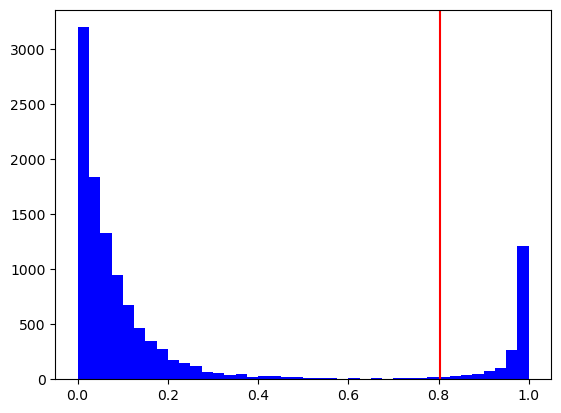

In [42]:
# Plot the predicted probabilities of default
plt.hist(preds_df_gbt['prob_default'], color = 'blue', bins = 40)

# Calculate the threshold with quantile
threshold = np.quantile(preds_df_gbt['prob_default'], 0.85)
print(threshold)

# Add a reference line to the plot for the threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

This is a histogram of the probabilities and a reference line for the threshold. An 85% acceptance rate shows the loans that will be accepted (left) and those that will be rejected (right) because of a bad PD. The threshold PD for this acceptance rate is 80.40%.

In [43]:
# Print the top 5 rows of the new data frame
preds_df_gbt = preds_df_gbt.drop(columns=['loan_status'])
test_pred_df = pd.concat([preds_df_gbt.reset_index(drop = True), y_test['loan_status'].reset_index(drop = True)], axis = 1)
test_pred_df = test_pred_df.rename(columns={"loan_status":"true_loan_status"})
print(test_pred_df.head())

# Create a subset of only accepted loans
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculate the bad rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

   prob_default  pred_loan_status  true_loan_status
0      0.982387                 1                 1
1      0.975163                 1                 1
2      0.003474                 0                 0
3      0.005457                 0                 0
4      0.119876                 0                 1
0.08256789137380191


The bad rate indicates the number of accepted loans that turned out to be defaults. The calculation for the bad rate is the number of defaults in our accepted loans divided by the total number of accepted loans. By setting our acceptance rate at 85% we were able to reduce the number of accepted default loans from 22% to only 8%.

In [44]:
# Add loan amount to the 
test_pred_df = pd.concat([test_pred_df.reset_index(drop = True), X_test['loan_amnt'].reset_index(drop = True)], axis = 1)

# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())

# Store the average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Set the formatting for currency, and print the cross tab
pd.options.display.float_format = '${:,.2f}'.format
print(pd.crosstab(test_pred_df['true_loan_status'], test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

count    11784.000000
mean      9556.283944
std       6238.005674
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
pred_loan_status              0              1
true_loan_status                              
0                $87,812,693.16     $86,006.56
1                 $7,903,046.82 $16,809,503.46


We can see that our bad rate of 8% represents an estimated loan value of 7.9 million dollars.

# Credit Strategy
We've looked at acceptance rates to calculate thresholds and we calculated bad rates to see how many defaults are accepted. Now, let's test many different acceptance rates and estimate our total expected loss.

[1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]


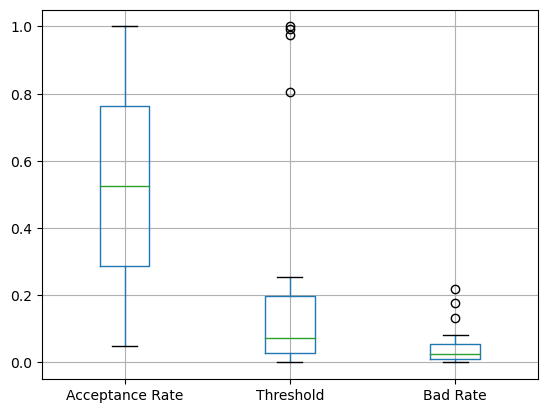

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loan Amnt,Estimated Value
0,1.000000,1.000000,0.219000,11784,"$9,556.28","$63,287,496.38"
1,0.950000,0.992000,0.178000,11194,"$9,556.28","$68,890,610.92"
2,0.900000,0.976000,0.133000,10605,"$9,556.28","$74,386,752.46"
3,0.850000,0.804000,0.083000,10016,"$9,556.28","$79,826,894.20"
4,0.800000,0.254000,0.061000,9427,"$9,556.28","$79,096,431.27"
5,0.750000,0.178000,0.052000,8838,"$9,556.28","$75,674,728.77"
6,0.700000,0.138000,0.043000,8249,"$9,556.28","$72,050,394.90"
7,0.650000,0.111000,0.036000,7660,"$9,556.28","$67,930,625.25"
8,0.600000,0.093000,0.030000,7070,"$9,556.28","$63,509,125.62"
9,0.550000,0.078000,0.027000,6481,"$9,556.28","$58,589,801.14"


In [45]:
accept_rates = [round(0.05 * i, 2) for i in range(20, 0, -1)]
print(accept_rates)

thresholds = []
bad_rates = []
num_accepted_loans = []
preds_df_gbt = test_pred_df

# Populate the arrays for the strategy table with a for loop
for rate in accept_rates:
    
    # Calculate and append the threshold for the acceptance rate
    thresh = np.quantile(preds_df_gbt['prob_default'], rate)
    thresholds.append(thresh.round(3))
    
    # Reassign the loan_status value using the threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)
    
    # Create a set of accepted loans using this acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    num_accepted_loans.append(len(accepted_loans))
    
    # Calculate and append the bad rate using the acceptance rate
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))
    
# Create a data frame of the strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates, num_accepted_loans), columns = ['Acceptance Rate','Threshold','Bad Rate', 'Num Accepted Loans'])

# Visualize the distributions in the strategy table with a boxplot
strat_df[['Acceptance Rate','Threshold','Bad Rate']].boxplot()
plt.show()

# Add average loan amount
strat_df['Avg Loan Amnt'] = np.mean(test_pred_df['loan_amnt']).round(2)

# Add estimated portfolio value
strat_df['Estimated Value'] = ((strat_df['Num Accepted Loans'] * (1 - strat_df['Bad Rate'])) * strat_df['Avg Loan Amnt']) \
                              - (strat_df['Num Accepted Loans'] * strat_df['Bad Rate'] * strat_df['Avg Loan Amnt'])

# Print the entire table
pd.options.display.float_format = None
strat_df.style.format({"Avg Loan Amnt": "${:,.2f}", "Estimated Value": "${:,.2f}"})

To discover the bad rate an impact of each acceptance rate we create a strategy table. We can choose our acceptance rate based on our overall strategy for the loan portfolio. For each acceptance rate, we calculate and store the threshold, apply it to the loans, create a subset called accepted loans, and then calculate and store the bad rate. We also add columns for number of accepted loans, average loam amount and the estimated portfolio value. The estiamted portfolio value is the average value of the accepted non-defaults minus the average value of accepted defaults. There is a trade-off between acceptance and bad rate.

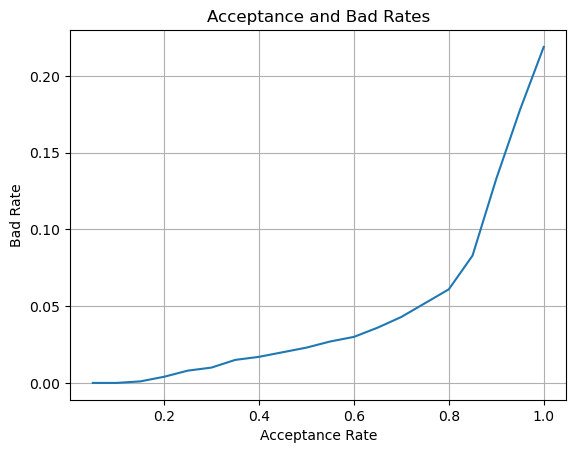

In [46]:
# Plot the strategy curve
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.grid()
plt.show()

As expected the bad rate increases as we increase our acceptance rate. The bad rates are very low up until the acceptance rate 0.6 where they suddenly increase. This infliction point is probably a good indicator of what our acceptance rate should be.

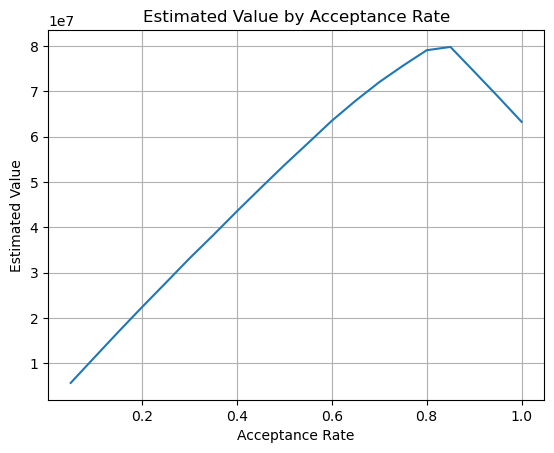

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loan Amnt,Estimated Value
3,0.850000,0.804000,0.083000,10016,"$9,556.28","$79,826,894.20"


In [47]:
# Create a line plot of estimated value
plt.plot(strat_df['Acceptance Rate'], strat_df['Estimated Value'])
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.grid()
plt.show()

# Print the row with the max estimated value
strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])].style.format({"Avg Loan Amnt": "${:,.2f}", "Estimated Value": "${:,.2f}"})

With our credit data and our estimated average loan value, we clearly see that the acceptance rate 0.85 has the highest potential estimated value. Normally, the allowable bad rate is set, but we can use analyses like this to explore other options.

In [48]:
# Print the first five rows of the data frame
print(preds_df_gbt.head())

# Calculate the bank's expected loss and assign it to a new column
preds_df_gbt['expected_loss'] = preds_df_gbt['prob_default'] * 1 * preds_df_gbt['loan_amnt']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(preds_df_gbt['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

   prob_default  pred_loan_status  true_loan_status  loan_amnt
0      0.982387                 1                 1      15000
1      0.975163                 1                 1      11200
2      0.003474                 1                 0      15000
3      0.005457                 1                 0      10800
4      0.119876                 1                 1       3000
Total expected loss:  $27,084,153.38


The expected loss (EL) of a loan is the probability of default (PD) times loss given default (LGD) times exposure at default (EAD).

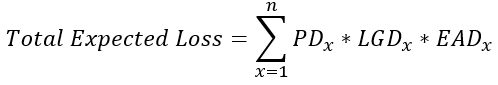

In this case the EAD is the full value of the loan and the LGD is 100%. This means that a default on each the loan is a loss of the entire amount.

This is the total expected loss for the entire portfolio using the gradient boosted tree. \\$27 million may seem like a lot, but the total expected loss would have been over $28 million with the logistic regression. Some losses are unavoidable, but your work here might have saved the company a million dollars!

# Conclusion
In this project we started by exploring the loan data for missings and outliers. We alleviated these problems through varying data cleaning steps.

We constructed a logistic regression model. We looked at the coefficients to find those columns with the highest explanatory power. We also one hot encoded categorical columns so we could use them in our model. By splitting our data into a trainings and test set we could afterwards evaluate the performance of our model. For this we looked at the precision and recall values as well as the AUC of the ROC curve. We also found the threshold PD for determing the loan status by looking at the trade off between default and non-default recall.

Then we looked at gradient boosted trees using XGBoost. By tweaking the hyperparameters of our model we were able to increase the performance. We also undersampled our data set to account for that fact that we have more non-defaults in it. We used similar techniques as the logsitic regression for model evaluation and quikly noticed this model performs a lot better.

Finally we saw how we could set our acceptance rate based on the number of defaults we were willing to take in our portfolio. By linking the bad rate and estimated value to our acceptance rates we were able to determine the optimal rate. This allowed us to calculate the total expected loss for our loan portfolio.